In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [21]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import numpy as np
from collections import defaultdict
import re
import random

from lib.sde.grn.grn4 import GRNMain4 as GRNMain
from lib.sde.mutate import mutate_grn4 as GRNMain
from lib.ga.utils import weighted_selection
from lib.ga.objective import Objective
from jf.profiler import Profiler
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L

from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)

from lib.analyser import show_curve, show_curve_progenitor
from lib.utils import pick_best, pick_last

from anndata import AnnData
import scanpy as sp

In [3]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)

In [4]:
class Solution:
    def __init__(self, grn):
        self.grn = grn
        
    def copy(self):
        return Solution(self.grn.copy())
        
    def mutate(self):
        mutate_grn(self.grn)

In [5]:
def get_bb(grn):
    ccls = factories["grn4"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=7, max_pop_size=5e2,
            cell_cls=ccls, end_time=86, start_time=56, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks, record_population=True)
    return bb

In [6]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [7]:
exporter = Exporter(name="check_simple_obj_test")

Exporting at output/check_simple_obj_test


In [8]:
best_sol = pick_best(exporter.load(pick_last(exporter)))

In [9]:
bb = get_bb(best_sol.grn)

In [10]:
bb.run()

True

## Setup scanpy

In [33]:
def build_scanpy_dataset(bb, min_age=0, max_age=1e6):
    # export expressions
    vec_age = []
    vec_gene_quantity = []
    for age in bb.snapshots:
        if age < min_age or age > max_age:
            continue
        for gene_quantity in bb.snapshots[age]["population"].values():
            vec_age.append(age)
            vec_gene_quantity.append(gene_quantity["quantity"])

    n_obs = len(vec_age)
    id_cells = np.arange(n_obs, dtype=int).astype(str)
    
    # metadata
    id_genes = np.array([f"gene_{i}" for i in range(len(vec_gene_quantity[0]))])
    obs_meta = pd.DataFrame({
        "age": np.array(vec_age)
    }, index=id_cells)
    
    # build dataset
    print(np.array(vec_gene_quantity).shape)
    df = pd.DataFrame(np.array(vec_gene_quantity), columns=id_genes, index=id_cells)
    dts = AnnData(df, obs=obs_meta)
    
    return dts

In [22]:
dts = build_scanpy_dataset(bb)

(9677, 5)


In [25]:
sp.pp.neighbors(dts)

sp.tl.umap(dts)

sp.pl.umap(dts, color="age")

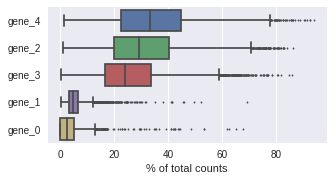

In [26]:
sp.pl.highest_expr_genes(dts, n_top = 5, save = False)

In [ ]:
sp.pl.umap(dts, color="age", cmap="viridis")

In [82]:
dts_small = build_scanpy_dataset(bb, 65, 85)

(6332, 5)


In [ ]:
sp.pp.neighbors(dts_small)
sp.tl.umap(dts_small)
sp.pl.umap(dts_small, color="age")

In [ ]:
sp.pl.umap(dts_small, color="gene_4")

In [85]:
df_s = dts_small.to_df()

In [86]:
df_s.corr()

,gene_0,gene_1,gene_2,gene_3,gene_4
gene_0,1.000000,-0.046271,-0.005208,0.002863,-0.014964
gene_1,-0.046271,1.000000,-0.027557,0.012466,0.065882
gene_2,-0.005208,-0.027557,1.000000,0.149020,0.014071
gene_3,0.002863,0.012466,0.149020,1.000000,0.057710
gene_4,-0.014964,0.065882,0.014071,0.057710,1.000000


In [92]:
best_sol.grn

>> G_0: init: 2.25; noise: 0.53; b: 2.32; m: 7.39; expr: 1.00; deg: 0.10; theta: 0.66; asym: 3.21; tree : (5 OR 0)
>> G_1: init: 1.62; noise: 0.16; b: 0.90; m: 7.28; expr: 1.00; deg: 0.10; theta: 1.55; asym: 4.15; tree : 5
>> G_2: init: 1.24; noise: 0.21; b: 1.66; m: 1.07; expr: 1.00; deg: 0.10; theta: 4.63; asym: 2.86; tree : NOT 1
>> G_3: init: 0.85; noise: 0.19; b: 3.49; m: 9.57; expr: 1.00; deg: 0.10; theta: 4.49; asym: 3.62; tree : 2
>> G_4: init: 1.43; noise: 0.41; b: 0.59; m: 6.49; expr: 1.00; deg: 0.10; theta: 6.90; asym: 2.40; tree : NOT 5

In [93]:
sp.tl.leiden(dts_small, key_added = "leiden_1.0")

In [94]:
sp.tl.louvain(dts_small, resolution=0.2, key_added = "louvain_1.0") # default resolution in 1.0

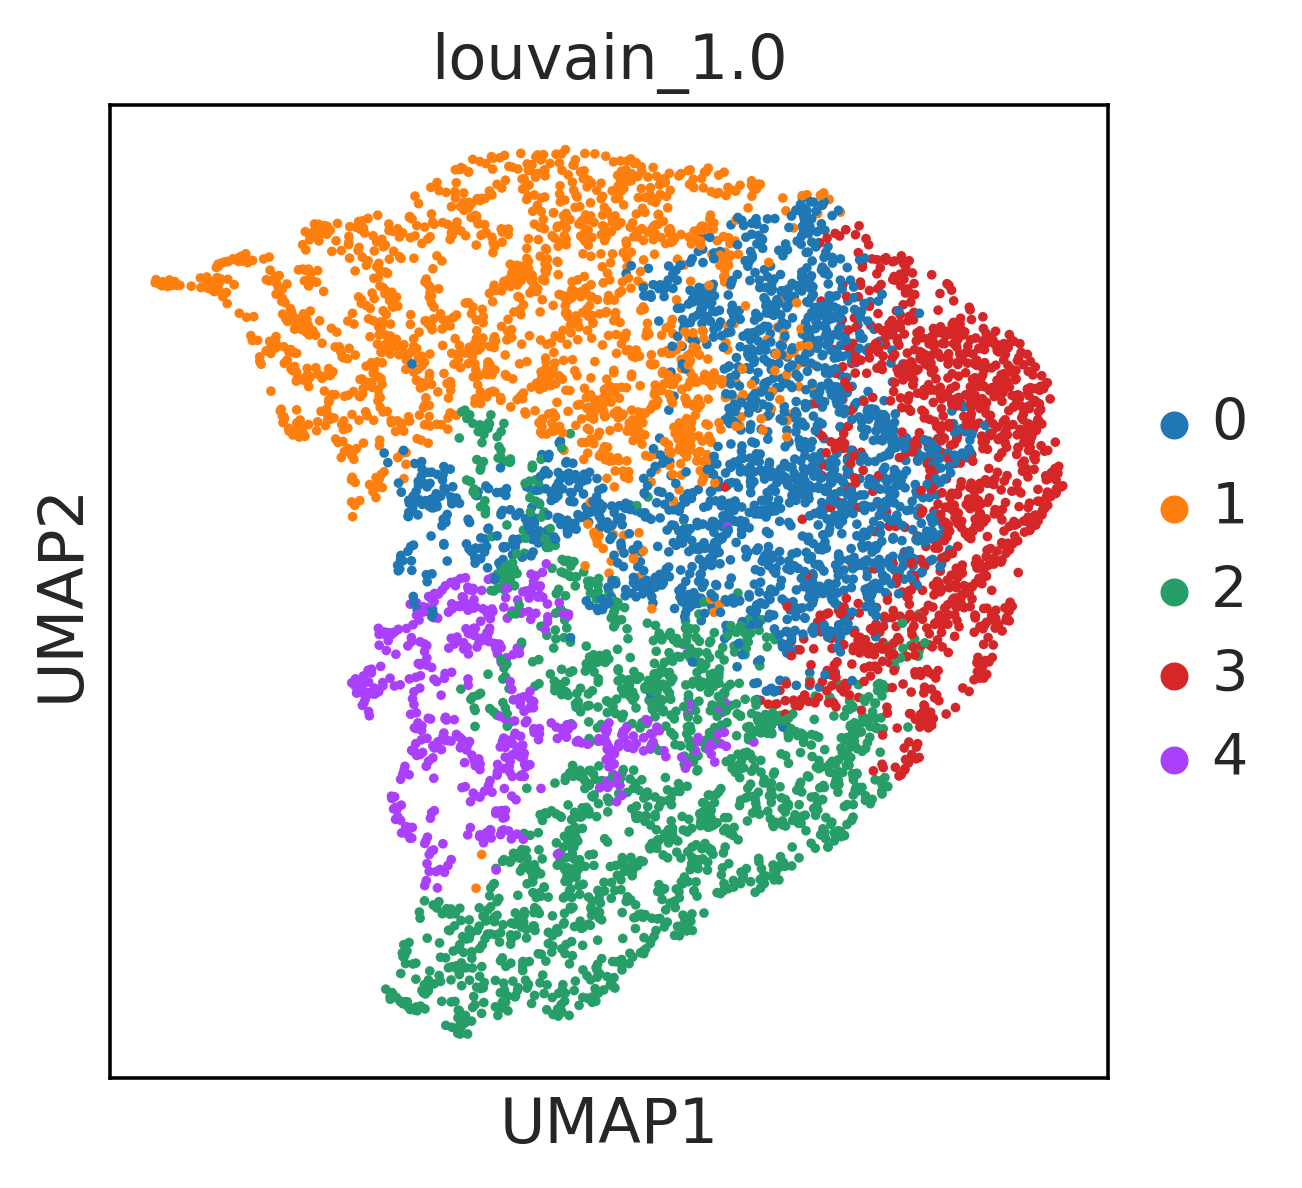

In [95]:
sp.pl.umap(dts_small, color='louvain_1.0')

In [96]:
sp.settings.set_figure_params(dpi=160)

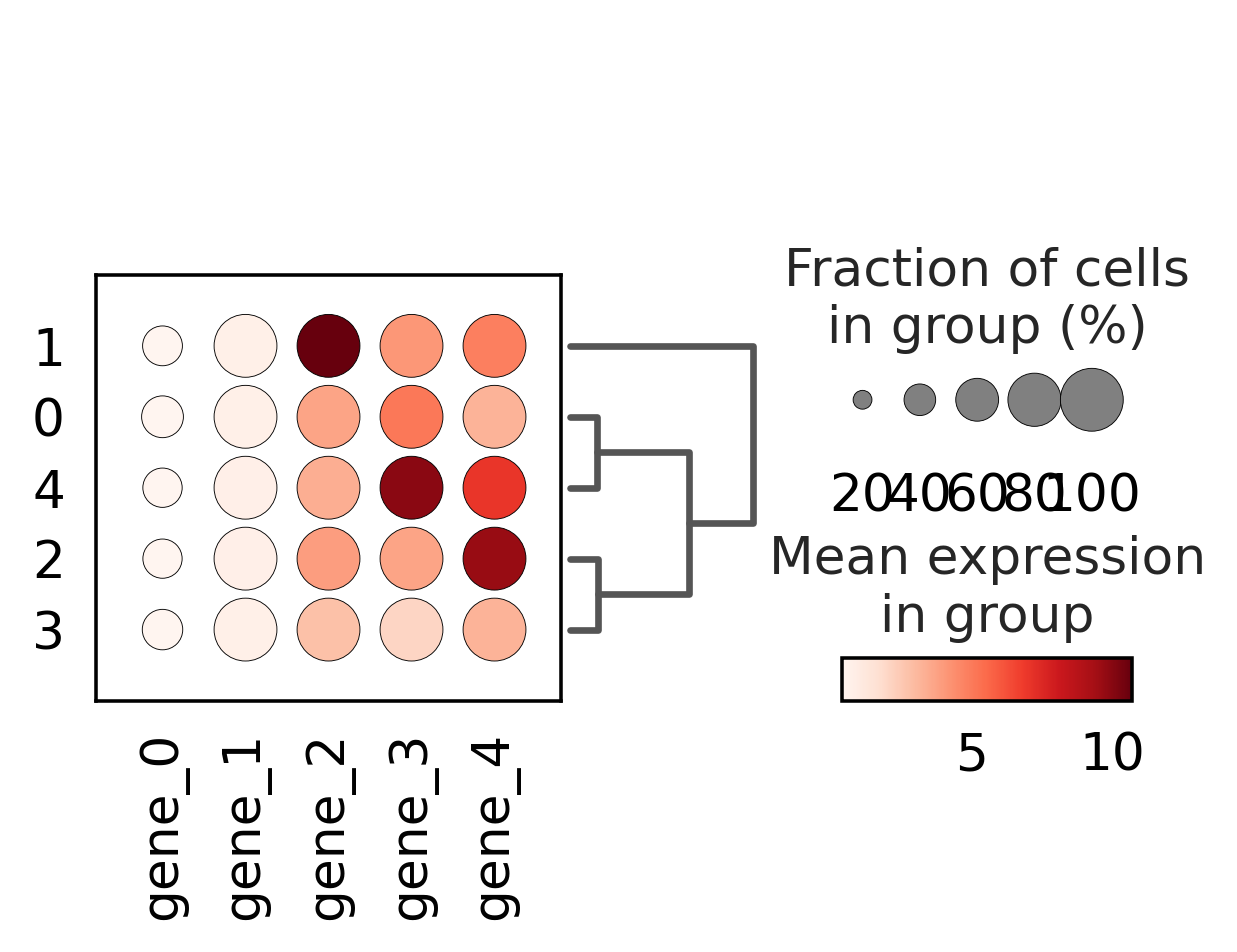

In [97]:
sp.pl.dotplot(dts_small, dts_small._var.index, groupby='louvain_1.0', dendrogram=True)